Qui troverai l'ultimo passo "dell'avventura" iniziata con [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/) in cui riporto l'andamento del PM10 nel nord Italia nell'ultimo decennio. Il come ho proceduto all'analisi è riportato in [quest'altro articolo](https://massimilianomoraca.me/blog/pygis-blog/analisi-dellandamento-del-pm10-nel-nord-italia/).

Lo scopo dell'articolo che stai per leggere è visualizzare su mappa le aree di analisi, cosa che fino ad ora non avevo mostrato.

Tutto l'iter è stato bello lungo ed è per questo che l'ho dovuto suddividere in ben tre differenti articoli.

# Prima di iniziare

## Librerie

Come per tutti gli [articoli di PyGIS-Blog](https://massimilianomoraca.me/blog/pygis-blog/) inizio con l'elenco delle librerie usate. Una menzione speciale è per la funzione `xarray.open_mfdataset` perchè mi ha consentito di velocizzare tantissimo la lettura di tutti i file `.nc` grazie al nativo supporto a `dask.delayed`. 

Devo approfondire Dask appena ho tempo e [Dask Delayed](https://docs.dask.org/en/stable/delayed.html) sembra un buon punto di partenza pratico su cui lavorare per il mio solito training on the job :)

In [1]:
from pathlib import Path
import xarray as xr
import rioxarray

## Fonti dati

Come già spiegato nei precedenti articoli di questa involontaria miniserie, i dati usati sono quelli distributi dal Copernicus Atmosphere Monitoring Service. In particolare ho usato dati con una copertura temporale che va dal 2013 a marzo 2024.

In [2]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

L'area geografica è sempre quella dei precedenti due articoli, la riporto comunque di seguito per completezza.

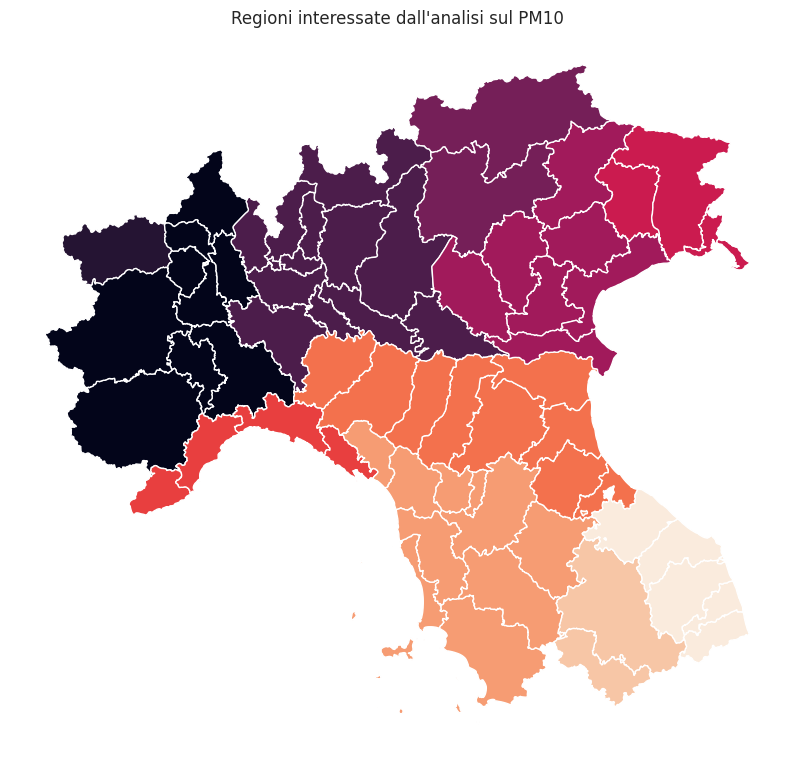

# Singolo file

## Lettura del `.nc`

Prima di iterare tutto il processo sull'intero arco temporale ho preferito effettuare delle verifiche su un solo anno, anche per prendere meglio confidenza con i dati.

In [4]:
single_dataset = xr.open_dataset(
    filename_or_obj='/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc',
    engine="netcdf4",
    decode_coords="all",
)

single_dataset

<xarray.Dataset> Size: 163MB
Dimensions:                  (time: 8760, lon: 91, lat: 51)
Coordinates:
  * time                     (time) datetime64[ns] 70kB 2013-01-01 ... 2013-1...
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 163MB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Come si può vedere, il Dataset del 2013 è composto da 8760 ore (24h x 365d) per un peso di ben 163MB. Ricordo che la risoluzione spaziale di questi dati è circa 7.5km x 7.5km.

### Test singolo giorno

Di seguito punto all'estrazione e visualizzazione di una singola ora di un singolo giorno.

In [7]:
target_test_time = '2013-07-09T13:00:00'

target_hour_selection = single_dataset.sel(time=target_test_time) #.to_array().squeeze()
#target_hour_sel = target_hour_sel.rename({'lon': 'x', 'lat': 'y'})

target_hour_selection

<xarray.Dataset> Size: 20kB
Dimensions:                  (lon: 91, lat: 51)
Coordinates:
    time                     datetime64[ns] 8B 2013-07-09T13:00:00
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
Data variables:
    particulate_matter_10um  (lat, lon) float32 19kB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [18]:
target_hour_selection.min().to_array().values[0], target_hour_selection.max().to_array().values[0]

(2.1810555, 37.6252)

Nell'ora presa in considerazione si nota che il PM10 minimo era pari a 2.18 µg/m3 ed il massimo era 37.62 µg/m3

## Calcolo media giornaliera

In [7]:
daily_data = single_dataset.resample(time='D').mean('time')  

daily_data

<xarray.Dataset> Size: 7MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 7MB dask.array<chunksize=(1, 51, 91), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [8]:
daily_data.dims

FrozenMappingWarningOnValuesAccess({'lon': 91, 'lat': 51, 'time': 365})

In [9]:
daily_data.sizes

Frozen({'lon': 91, 'lat': 51, 'time': 365})

## Selezione delle sole celle che sforano il limite di 50

In [10]:
daily_data_target = daily_data.copy() #.where(daily_data['particulate_matter_10um'] >= 50)

# Create a new variable with values set to 1 where the condition is met, and 0 otherwise
daily_data_target['particulate_matter_10um'] = xr.where(daily_data['particulate_matter_10um'] >= 50, 1, 0)

daily_data_target

<xarray.Dataset> Size: 14MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 14MB dask.array<chunksize=(1, 51, 91), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

### Test singolo giorno

In [11]:
target_data_sel = daily_data_target.sel(time=target_test_time[:10])
target_data_sel = target_data_sel.rename({'lon': 'x', 'lat': 'y'})
target_data_sel.astype('float32').rio.to_raster(test_folder.joinpath(f"target_data_sel_{target_test_time[:10]}.tif"), driver="GTiff")

target_data_sel

<xarray.Dataset> Size: 38kB
Dimensions:                  (x: 91, y: 51)
Coordinates:
  * x                        (x) float64 728B 6.0 6.1 6.2 6.3 ... 14.8 14.9 15.0
  * y                        (y) float64 408B 42.0 42.1 42.2 ... 46.8 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
    time                     datetime64[ns] 8B 2013-01-01
Data variables:
    particulate_matter_10um  (y, x) int64 37kB dask.array<chunksize=(51, 91), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

## Conteggio degli sforamenti in un anno

In [12]:
year_data = daily_data_target.resample(time='YE').sum('time')  

year_data

<xarray.Dataset> Size: 38kB
Dimensions:                  (lon: 91, lat: 51, time: 1)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
  * time                     (time) datetime64[ns] 8B 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 37kB dask.array<chunksize=(1, 51, 91), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

### Test singolo anno

In [13]:
target_data_year_sel = year_data.rename({'lon': 'x', 'lat': 'y'}).to_array().squeeze()
target_data_year_sel.astype('float32').rio.to_raster(test_folder.joinpath(f"target_data_year_sel_{target_test_time[:4]}.tif"), driver="GTiff")

target_data_year_sel, target_data_year_sel.shape

(<xarray.DataArray (y: 51, x: 91)> Size: 37kB
 dask.array<getitem, shape=(51, 91), dtype=int64, chunksize=(51, 91), chunktype=numpy.ndarray>
 Coordinates:
   * x            (x) float64 728B 6.0 6.1 6.2 6.3 6.4 ... 14.7 14.8 14.9 15.0
   * y            (y) float64 408B 42.0 42.1 42.2 42.3 ... 46.7 46.8 46.9 47.0
     spatial_ref  int64 8B ...
     level        int64 8B ...
     time         datetime64[ns] 8B 2013-12-31
     variable     <U23 92B 'particulate_matter_10um'
 Attributes:
     Conventions:  CF-1.7
     Title:        CAMS European air quality interim reanalysis
     Provider:     COPERNICUS European air quality service
     Production:   COPERNICUS Atmosphere Monitoring Service
     pollutant:    particulate_matter_10um
     sea_level:    0,
 (51, 91))

# Analisi di tutti i file

In [ ]:
%%time

complete_dataset = []

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    complete_dataset.append(dataset)

full_dataset = xr.concat(complete_dataset, dim="time")

full_dataset

In [ ]:
time_coordinates = full_dataset['time'].values

time_coordinates, len(time_coordinates)

In [ ]:
########################
# TEST controllo dimensioni

In [ ]:
# %%time
# import pandas as pd
# 
# data_list = []
# 
# for time in time_coordinates:
#     single_hour = full_dataset.sel(time=time)
#     #print(single_hour)
# 
#     lon = single_hour['lon']
#     lat = single_hour['lat']
#     
#     lat_pixel_size = float(abs(lat[1] - lat[0]).values)
#     lon_pixel_size = float(abs(lon[1] - lon[0]).values)
#     diff_pixel_size = lat_pixel_size - lon_pixel_size
# 
#     # first_lon = lon.values[0]
#     # last_lon = lon.values[-1]
#     # first_lat = lat.values[0]
#     # last_lat = lat.values[-1]
#     # 
#     # shape = single_hour.to_array().shape
#     # dims = single_hour.to_array().dims
#     # size = single_hour.to_array().size
#     # crs = single_hour.to_array().rio.crs
#     # 
#     # data = [
#     #     time, shape, dims, size, 
#     #     str(crs), str(dict(first_lon=first_lon, last_lon=last_lon, first_lat=first_lat, last_lat=last_lat)), str(dict(lon_pixel_size=lon_pixel_size, lat_pixel_size=lat_pixel_size)),
#     #     diff_pixel_size
#     # ]
#     
#     data = [
#         time, diff_pixel_size
#     ]
#     #print(data)
#     data_list.append(data)
# 
#     #break
# 
# df = pd.DataFrame(data_list, columns=['time', 'diff_pixel_size'])
# #df = pd.DataFrame(data_list, columns=['time', 'shape', 'dims', 'size', 'crs', 'lon_lat_coords', 'pixel_size', 'diff_pixel_size'])
# 
# df

In [ ]:
# df_size = df.groupby('size').count()
# 
# df_size

In [ ]:
# df_lon_lat_coordinates = df.groupby('lon_lat_coords').count()
# 
# df_lon_lat_coordinates

In [ ]:
# df_pixel_size = df.groupby('pixel_size').count()
# 
# df_pixel_size

In [ ]:
# df_diff_pixel_size = df.groupby('diff_pixel_size').count()
# 
# df_diff_pixel_size

In [ ]:
########################
########################
########################

In [ ]:
%%time

full_dataset = full_dataset.sortby('time')

full_dataset

In [ ]:
full_dataset_day_time = full_dataset['time'].values

full_dataset_day_time, len(full_dataset_day_time)

In [ ]:
########################
# TEST ORARIO

In [ ]:
# for x in full_dataset_day_time:
#     single_year_data = full_dataset.sel(time=x)
#     single_year_data = single_year_data.rename({'lon': 'x', 'lat': 'y'})
# 
#     t_day = str(x)[:19]
#     single_year_data.astype('float32').rio.to_raster(test_folder.joinpath(f"full_dataset_hour_{t_day}.tif"), driver="GTiff")
# 
#     break

In [ ]:
########################
########################
########################

In [ ]:
%%time

full_dataset_daily_data = full_dataset.resample(time='D').mean('time')  

full_dataset_daily_data

In [ ]:
########################
# TEST GIORNO con resample

In [ ]:
# post_rm_day_time = full_dataset_daily_data['time'].values
# 
# post_rm_day_time, len(post_rm_day_time)

In [ ]:
# for rm_day in post_rm_day_time:
#     single_year_data = full_dataset_daily_data.sel(time=rm_day)
#     single_year_data = single_year_data.rename({'lon': 'x', 'lat': 'y'})
# 
#     t_day = str(rm_day)[:10]
#     single_year_data.astype('float32').rio.to_raster(test_folder.joinpath(f"full_dataset_daily_data_{t_day}.tif"), driver="GTiff")
# 
#     break

In [ ]:
########################
########################
########################

In [ ]:
%%time

full_dataset_daily_data_target = full_dataset_daily_data.copy()  #.where(full_dataset_daily_data['particulate_matter_10um'] >= 50)
# Apply boolean indexing to set values greater than 50 to 1
full_dataset_daily_data_target['particulate_matter_10um'] = xr.where(full_dataset_daily_data_target['particulate_matter_10um'] > 50, 1, 0)

full_dataset_daily_data_target

In [ ]:
########################
# TEST GIORNO con filtro

In [ ]:
# post_filter_day_time = full_dataset_daily_data_target['time'].values
# 
# post_filter_day_time, len(post_filter_day_time)

In [ ]:
# for day in post_filter_day_time:
#     single_year_data = full_dataset_daily_data_target.sel(time=day)
#     single_year_data = single_year_data.rename({'lon': 'x', 'lat': 'y'})
# 
#     t_day = str(day)[:10]
#     single_year_data.astype('float32').rio.to_raster(test_folder.joinpath(f"post_filter_day_time_{t_day}.tif"), driver="GTiff")
# 
#     break

In [ ]:
########################
########################
########################

In [ ]:
full_dataset_year_data = full_dataset_daily_data_target.resample(time='YE').sum('time')  
# full_dataset_year_data = full_dataset_year_data.sortby(["time", "lat", "lon"])
# full_dataset_year_data.rio.write_crs("epsg:4326", inplace=True)

full_dataset_year_data

In [ ]:
# # Group the data by year
# grouped_by_year = full_dataset_daily_data_target.groupby('time.year')
# 
# grouped_by_year

In [ ]:
# # Aggregate the data by summing
# full_dataset_year_data = grouped_by_year.sum(dim='time')
# 
# full_dataset_year_data

In [ ]:
# %%time
# 
# full_dataset_year_data.to_netcdf(processed_data_path.joinpath("full_dataset_year_data.nc"))

In [ ]:
########################
# TEST ANNO

In [ ]:
# #year_time = full_dataset_year_data['time'].values
# year_time = full_dataset_year_data['year'].values
# 
# year_time, len(year_time)

In [ ]:
# #for year in year_time[11:12]: # 2024
# for year in year_time[:11]:
#     single_year_data = full_dataset.sel(time=year)
#     single_year_data = single_year_data.rename({'lon': 'x', 'lat': 'y'})
# 
#     t_year = str(year)[:4]
#     single_year_data.astype('float32').rio.to_raster(test_folder.joinpath(f"full_dataset_year_data_{t_year}.tif"), driver="GTiff")
# 
#     #break

In [ ]:
########################
########################
########################

In [48]:
nc_files_ = nc_files[1:2]

nc_files_

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc')]

In [79]:
%%time
from rasterio.enums import Resampling

dataset_list = []
variable = 'particulate_matter_10um'
target_shape = (50, 90)

#for nc_file in nc_files_:
for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    dataset = dataset.sortby('time')
    
    daily_mean = dataset.resample(time='D').mean('time')  

    # Create a new variable with values set to 1 where the condition is met, and 0 otherwise
    anomaly = daily_mean.copy()
    anomaly[variable] = xr.where(daily_mean[variable] >= 50, 1, 0)

    # ## TEST
    # test_time = '2013-01-01T00:00:00'
    # test_data_sel = anomaly.sel(time=test_time[:10])
    # test_data_sel = test_data_sel.rename({'lon': 'x', 'lat': 'y'})
    # test_data_sel.astype('float32').rio.to_raster(test_folder.joinpath(f"test_data_sel_{test_time[:10]}.tif"), driver="GTiff")
    # ## TEST
    
    out_layer = anomaly.resample(time='YE').sum('time')  
    year = str(out_layer['time'].values[0])[:4]

    # ## TEST
    # test_data_year_sel = out_layer.rename({'lon': 'x', 'lat': 'y'}).to_array().squeeze()
    # test_data_year_sel.astype('float32').rio.to_raster(test_folder.joinpath(f"test_data_year_sel_{test_time[:4]}.tif"), driver="GTiff")
    # ## TEST
        
    out_layer_final = out_layer.rename({'lon': 'x', 'lat': 'y'}).to_array().squeeze()
    out_layer_final.astype('float32').rio.to_raster(test_folder.joinpath(f"processed_{year}.tif"), driver="GTiff")


CPU times: user 17.7 s, sys: 362 ms, total: 18 s
Wall time: 21.3 s
